# Práctica 1. Asteroides peligrosos

### Objetivo 

El etiquetado de imágenes es una tarea ardua. Es por ello y también debido a sus aplicaciones prácticas que los  científicos  llevan  un  tiempo  intentando  mejorar  los  métodos  para  clasificarlas  automáticamente.  En  la aduana del aeropuerto de Madrid se intenta luchar contra el tráfico de  animales exóticos. Para ello se vaa crear un clasificador que realizando una foto a un animal (en este caso monos) pueda decidir si pertenece a una  especie  en  peligro  de  extinción  o  no.  Dicho  clasificador  funcionará  mediante  un  set  de  entrenamiento donde   se   buscará  un  plano  que  divida  las  diferentes  clases   dispuesta  enun  espacio  n-dimensional dependiendo de sus características. Muestra todos los resultadosdel algoritmopaso a paso.Para ello usaremos el dataset “monos.zip” que se encuentra en scikit-learn. Elige  el clasificador que más se adapte  de  entre  los  vistos  en  clase  y  usa  scikit-learn  junto  con  las  librerías  que  necesites  para  resolver  las siguientes cuestiones

### Cuestiones 

1)Crea un clasificador que permita saber qué especie de monoes a partir de una imagen. Realiza al menos dosconfiguraciones y dibuja una tabla donde se muestre la precisión con la que clasifican. (1 punto)

2)Elige 5 imágenes de diferentes especiesque no hayas usado ni para entrenar el modelo, ni para evaluarlo  y  clasifícalas. Usa  para  ello  el  modelo  que  mejor  clasifique  de  los  del  punto  anterior. Índica con que error ha funcionado el clasificador. (1 punto)

#### Librerias

In [1]:
from sklearn import datasets
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from random import randint
from sklearn.preprocessing import StandardScaler
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import csv
import os
import random
import cv2

import warnings
warnings.filterwarnings('ignore')

## 1. Preparación del dataset

Cargamos las imagenes de los monos, dividimos los datos a utilizar y los transformamos para poder utilizarlos en el apartado de clasificación

In [4]:
datos_imagenes = []
for (dirpath, dirnames, filenames) in os.walk("TrainData"):
    datos_imagenes += [os.path.join(dirpath, file) for file in filenames]

In [5]:
""" 
Función para convertir los ficheros de imágenes en array de píxeles con un tamaño
redimensionado para mejorar el rendimiento del programa.
Parámetros:
    - file_path: Dirección de los ficheros.
Devuelve:
    - La array de píxeles de la imagen redimensionada.
"""
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    b,g,r = cv2.split(img)
    img2 = cv2.merge([r,g,b])
    return cv2.resize(img2, (128, 96), interpolation=cv2.INTER_CUBIC)

In [6]:
""" 
Función leer todas las imágenes y juntarlas en una una array de píxeles:
    - images: Dirección de los ficheros.
Devuelve:
    - La array de píxeles de todas las imágenes.
"""
def prep_data(images):
    count = len(images)
    data = np.ndarray((count, 3, 128, 96), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%1000 == 0: 
            print("Procesados ", i, " archivos de ", count)
    
    return data

In [10]:
""" 
Función para generar la salida espera para la red neuronal.
Devuelve:
    - Las etiquetas de salida de la red neuronal.
"""
def GenerarEtiquetas(imagenes):
    #datos = pd.read_csv('Recursos Lab 3/monos/monkey_labels.txt')

    etiquetas = []

    for i in range(0, len(imagenes)):

        if i % 1000 == 0:
            print("Generando tags... ", i, " de ", len(imagenes))

        nombre_fichero = imagenes[i].split("/")  
        nombre_fichero = nombre_fichero[3].split("\\")
        clase = nombre_fichero[1]

        if clase == "BacterialPneumonia":
            etiquetas.append(0)
        elif clase == "COVID-19":
            etiquetas.append(1)
        elif clase == "Normal":
            etiquetas.append(2)    
        elif clase == "OversampledAugmentedCOVID-19":
            etiquetas.append(3)
        elif clase == "ViralPneumonia":
            etiquetas.append(4)
  
        
    #etiquetas = np_utils.to_categorical(etiquetas)
    return etiquetas

In [11]:
Dir_Entrenamiento = "Recursos Lab 3/monos/TrainData/"
Dir_Test = "Recursos Lab 3/monos/Valdata/"

datos_entrenamiento = []
for (dirpath, dirnames, filenames) in os.walk(Dir_Entrenamiento):
    datos_entrenamiento += [os.path.join(dirpath, file) for file in filenames]
# Se barajan imágenes, es decir, cambia la posicion de los elementos, en la lista de entrenamiento
random.shuffle(datos_entrenamiento)

# Se transforman las imágenes de entrenamiento en arrays de píxeles
conjunto_entrenamiento = prep_data(datos_entrenamiento)

# Se generan las etiquetas de las imagenes de entrenamiento
etiquetas_entrenamiento = GenerarEtiquetas(datos_entrenamiento)


datos_test = []
for (dirpath, dirnames, filenames) in os.walk(Dir_Test):
    datos_test += [os.path.join(dirpath, file) for file in filenames]
# Se barajan imágenes, es decir, cambia la posicion de los elementos, en la lista de entrenamiento
random.shuffle(datos_test)

# Se transforman las imágenes de entrenamiento en arrays de píxeles
conjunto_validacion = prep_data(datos_test)

# Se generan las etiquetas de las imagenes de entrenamiento
etiquetas_validacion = GenerarEtiquetas(datos_test)



# Guardamos 5 fotos del conjunto de entrenamiento y sus eitqueta en una variable a parte para el ultimo ejercicio
numero = len(conjunto_entrenamiento) - 5
conjunto_prueba = conjunto_entrenamiento[numero:]
etiquetas_prueba = etiquetas_entrenamiento[numero:]

Realizamos un reshape a los conjuntos para poder utilizarlos al clasificar

In [12]:
conjunto_entrenamiento = conjunto_entrenamiento.reshape((len(conjunto_entrenamiento), - 2))
conjunto_validacion = conjunto_validacion.reshape((len(conjunto_validacion), - 2))
conjunto_prueba = conjunto_prueba.reshape((len(conjunto_prueba), - 2))

print("Hay " + str(len(conjunto_entrenamiento)) + " imagenes  de entrenamiento")
print("Hay " + str(len(conjunto_validacion)) + " imagenes  de validación")
print("Hay " + str(len(conjunto_prueba)) + " imagenes  de prueba")

ValueError: cannot reshape array of size 0 into shape (0,newaxis)

## 2. Construcción del modelo
Probaremos 2 configuraciones para saber cual de las 2 mejor clasifica

In [42]:
precisiones = []

### 2.1 Kernel lineal

In [43]:
# Creación del modelo.
modelo = svm.SVC(kernel='linear')

# Entrenamiento del modelo.
modelo.fit(conjunto_entrenamiento, etiquetas_entrenamiento)  

precision = round(accuracy_score(modelo.predict(conjunto_validacion), etiquetas_validacion), 2) *100 

# Imprimimos el resultado
print("El modelo tiene una precisión del: " + str(precision) + "%.")

# Agregamos la precisión a la lista.
precisiones.append(precision)

El modelo tiene una precisión del: 59.0%.


### 2.2 Kernel polinómico

In [45]:
mejor_grado = 0
mejor_precision = 0
rango = [0, 0.5, 1, 1.5, 2, 2.5]
for i in rango:
    print("i :", i)
    # Creación del modelo.
    modelo = svm.SVC(kernel='poly', degree=i)

    # Entrenamiento del modelo.
    modelo.fit(conjunto_entrenamiento, etiquetas_entrenamiento)  

    # Calculamos el procentaje de precisión del modelo.
    precision = round(accuracy_score(modelo.predict(conjunto_validacion), etiquetas_validacion) * 100, 1)
    
    # Si mejora la mejor precisión hasta el momento, guardamos el mejor grado.
    if mejor_precision < precision:
        mejor_precision = precision
        mejor_grado = i
    
# Creación del modelo.
modelo = svm.SVC(kernel='poly', degree=mejor_grado)

# Entrenamiento del modelo.
modelo.fit(conjunto_entrenamiento, etiquetas_entrenamiento)  

# Calculamos el procentaje de precisión del modelo.
precision = round(accuracy_score(modelo.predict(conjunto_validacion), etiquetas_validacion) * 100, 1)

# Imprimimos el resultado
print("El modelo tiene una precisión del: " + str(precision) + "% con degree: " + str(mejor_grado) + ".")
    
# Agregamos la precisión a la lista.
precisiones.append(precision)

i : 0
i : 0.5
i : 1
i : 1.5
i : 2
i : 2.5
El modelo tiene una precisión del: 58.8% con degree: 1.


## Precisiones

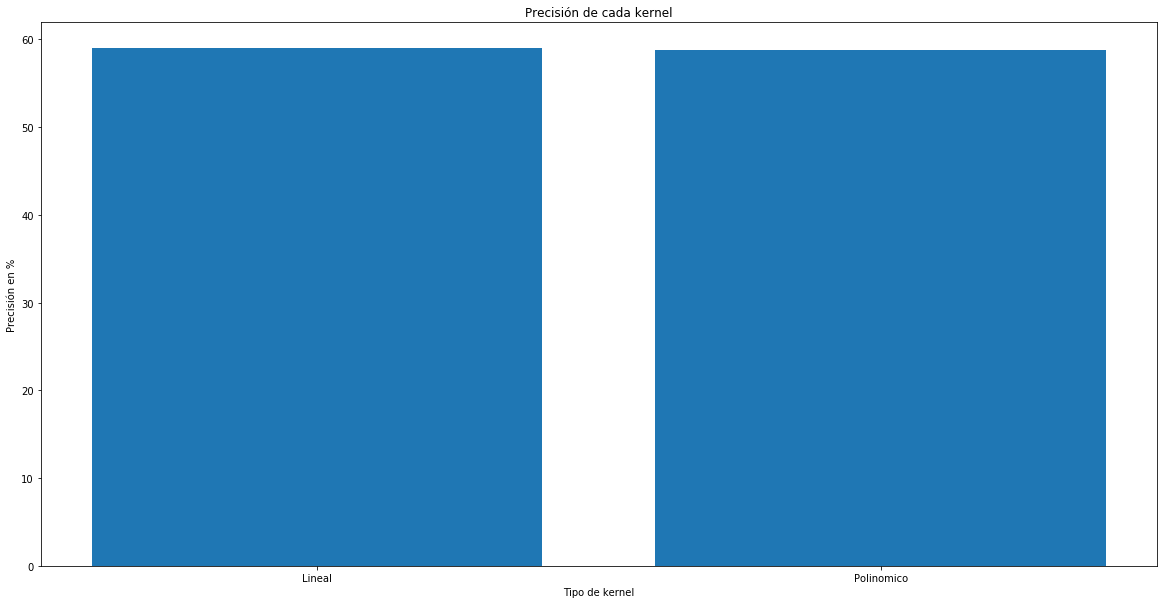

In [46]:
kernels = ["Lineal", "Polinomico"]
plt.subplots(figsize=(20, 10))
plt.title("Precisión de cada kernel")
plt.xlabel("Tipo de kernel")
plt.ylabel("Precisión en %")
plt.bar(kernels, precisiones)
plt.show()

## Mejor Modelo

In [49]:
# Creación del modelo.
modelo = svm.SVC(kernel='linear')

# Entrenamiento del modelo.
modelo.fit(conjunto_entrenamiento, etiquetas_entrenamiento)  

precision = round(accuracy_score(modelo.predict(conjunto_validacion), etiquetas_validacion), 2) *100 

# Imprimimos el resultado
print("El modelo tiene una precisión del: " + str(precision) + "%.")

El modelo tiene una precisión del: 59.0%.


El modelo tienen más de un 59% de precisión y ha clasificado correctamente cada mono en su clase.

# EJERCICIO 2 - CLASIFICAR 5 IMÁGENES NUEVAS

In [50]:
resultado = modelo.predict(conjunto_prueba)
print(resultado)
print(etiquetas_prueba)

[1 1 2 5 1]
[1, 1, 2, 5, 1]


Como podemos comprobar, El clasificador ha sido capaz de clasificar las 5 imagenes correctamente sin ningun error, pese a que la precisión del modelo no es muy alta